In [454]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import *
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
from transform_wrappers import *
import visualize as viz
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
import pandas as pd
from models import FNN
import attributions
device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [455]:
np.random.seed(13)
torch.manual_seed(13)
class p:
    n = 50000
    p = 100
idx_knockout = 12
window = 0
X = np.random.randn(p.n, p.p).astype(np.float32)
X_t = torch.rfft(torch.Tensor(X), signal_ndim=1)

# define y
band = X_t[:, idx_knockout - window: idx_knockout + window + 1]
band_mag = torch.pow(band[..., 0]**2 + band[..., 1]**2, 0.5)
band_mag_mean = torch.mean(band_mag, axis=1)
thresh = np.nanpercentile(band_mag_mean, 50)
y = (band_mag_mean > thresh).cpu().detach().numpy().astype(np.int)

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [456]:
# fit model
net = NeuralNetClassifier(
    FNN(p=p.p),
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None,
)
net.fit(X_train, y_train)
transform = modularize(lambda x: torch.irfft(x, signal_ndim=1)[:, :-1])
mt = Net_with_transform(model=net.module_, transform=transform).to('cpu')
print('test acc', net.score(X_test, y_test))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6925  0.6102
      2        0.5059  0.6137
      3        0.2218  0.6177
      4        0.1602  0.5833
      5        0.1330  0.5833
      6        0.1166  0.6175
      7        0.1055  0.6107
      8        0.0958  0.6101
      9        0.0874  0.6162
     10        0.0808  0.6132
test acc 0.95216


In [457]:
# x_torch = torch.Tensor(X_test[0].reshape(1, -1))
# x_t = torch.rfft(x_torch, signal_ndim=1).squeeze()
# results_individual = attributions.get_attributions(x_t, mt)

In [460]:
results = []
for i in tqdm(range(100)):
    x_torch = torch.Tensor(X_test[i].reshape(1, -1))
    x_t = torch.rfft(x_torch, signal_ndim=1).squeeze()
    results.append(attributions.get_attributions(x_t, mt))

100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


In [445]:
results = pd.DataFrame(results)

[1.0, 0.948, 0.929, 0.93]


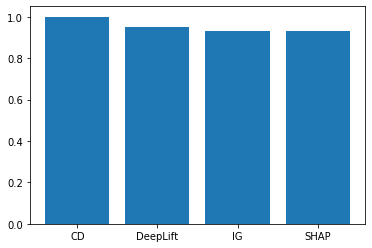

In [446]:
accs = []
ks = sorted(results.keys())
for k in ks:
#     print(k)
    vals = np.vstack(results[k])
#     print(vals.shape)
    args = np.argmax(vals, axis=1)
#     print(args)
    num_correct = np.sum(args == idx_knockout)
    accs.append(num_correct / vals.shape[0])
plt.bar(ks, accs)

print(accs)
plt.show()

In [462]:
prob = 0.948
num = 1000
print(np.sqrt(prob * (1-prob)) / np.sqrt(num))

0.007021111023192843


In [ ]:
# d = scores.size
# idxs = np.zeros(d).astype(bool)
# idxs[idx_zero - window: idx_zero + window + 1] = 1
# plt.plot(np.arange(d)[idxs], scores[idxs], 'o')
# plt.plot(np.arange(d)[~idxs], scores[~idxs], 'o')
# plt.show()